In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import math, time, os, datetime
import random

In [2]:
#DIFFERENCE
def set_seed(seed):
   torch.manual_seed(seed)
   torch.cuda.manual_seed_all(seed)
   np.random.seed(seed)
   random.seed(seed)
   torch.backends.cudnn.deterministic = True
   torch.backends.cudnn.benchmark = False

In [3]:
set_seed(5757)

In [ ]:
df = pd.read_parquet('data/data_sampled_16d_2025-03-28.parquet')

In [6]:
df.columns=df.columns=['gridID', 'Time', 'Destination', 'SmsIn', 'SmsOut', 'CallIn','CallOut', 'Internet']
df = df.drop('Destination', axis=1).groupby(["gridID", "Time"]).mean().fillna(0).reset_index()

# Option3
df.index=df['Time']
df_copy = df.copy()
col='Internet'
Selected_cols = ['gridID',col]
df = df_copy[Selected_cols]

sample_fct=0.5
grid_ids = np.random.choice(df_copy['gridID'].unique(), int(len(df_copy["gridID"].unique())*sample_fct))

In [25]:
col='Internet'
Selected_cols = ['gridID',col]
df = df_copy[Selected_cols]

df=df[df['gridID'].isin(grid_ids)]
# df = df[["gridID",col]]
df.index.name='startTime'

# Data scaling
scaler = StandardScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

## Adding contextual information
data_scaled['gridID'] = df['gridID']

# Create time-based features
data_scaled['month'] = data_scaled.index.month 
data_scaled['day_of_month'] = data_scaled.index.day
data_scaled['day_of_week'] = data_scaled.index.dayofweek
data_scaled['hour'] = data_scaled.index.hour
data_scaled['minute'] = data_scaled.index.minute

data_scaled.sort_index(inplace=True)

display(data_scaled)

,gridID,Internet,month,day_of_month,day_of_week,hour,minute
startTime,,,,,,,
2013-11-01 00:00:00,195,-0.561022,11,1,4,0,0
2013-11-01 00:00:00,794,-0.589667,11,1,4,0,0
2013-11-01 00:00:00,4513,-0.445258,11,1,4,0,0
2013-11-01 00:00:00,8773,1.603701,11,1,4,0,0
2013-11-01 00:00:00,4560,1.142285,11,1,4,0,0
...,...,...,...,...,...,...,...
2013-11-16 23:50:00,4513,-0.589094,11,16,5,23,50
2013-11-16 23:50:00,4467,0.509179,11,16,5,23,50
2013-11-16 23:50:00,3882,-0.165506,11,16,5,23,50


In [26]:
## Evaluation data
df_eval = pd.read_parquet('data/data_sampled_16d_eval_2025-03-31.parquet')

df_eval.columns=['gridID', 'Time', 'Destination', 'SmsIn', 'SmsOut', 'CallIn','CallOut', 'Internet']

df_eval = df_eval.drop('Destination', axis=1).groupby(["gridID", "Time"]).mean().fillna(0).reset_index()

df_eval.index=df_eval['Time']

df_eval_copy = df_eval.copy()

sample_fct=0.5

Selected_cols = ['gridID',col]
df_eval = df_eval_copy[Selected_cols]
grid_ids = np.random.choice(df_eval_copy['gridID'].unique(), int(len(df_eval_copy["gridID"].unique())*sample_fct))
df_eval=df_eval[df_eval['gridID'].isin(grid_ids)]
df_eval = df_eval[["gridID",col]]
df_eval.index.name='startTime'

df_eval_copy0 = df_eval.copy()

## NA imputation with meam
c_mean = df_eval[col].mean()
df_eval[col].fillna(c_mean, inplace=True)

# data_eval scaling
scaler = StandardScaler()
data_eval_scaled = pd.DataFrame(scaler.fit_transform(df_eval), columns=df_eval.columns, index=df_eval.index)

# Create time-based features 
data_eval_scaled['gridID'] = df_eval['gridID']
data_eval_scaled['month'] = data_eval_scaled.index.month 
data_eval_scaled['day_of_month'] = data_eval_scaled.index.day
data_eval_scaled['day_of_week'] = data_eval_scaled.index.dayofweek
data_eval_scaled['hour'] = data_eval_scaled.index.hour
data_eval_scaled['minute'] = data_eval_scaled.index.minute

data_eval_scaled.sort_index(inplace=True)
display(data_eval_scaled)

#
data_eval_2 = data_eval_scaled[data_eval_scaled.columns[data_eval_scaled.columns.isin([col])]] 
date_eval = data_eval_scaled.drop(['gridID', col], axis = 1) #
date_eval_tensor = torch.tensor(date_eval.values).cuda()
display(date_eval_tensor.shape)
display(data_eval_2.shape)


eval_tensor_2 = torch.tensor(data_eval_2.values, dtype=torch.float32).cuda()

C:\Users\VCLAB\AppData\Local\Temp\ipykernel_17000\2875464085.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_eval[col].fillna(c_mean, inplace=True)


,gridID,Internet,month,day_of_month,day_of_week,hour,minute
startTime,,,,,,,
2013-11-18 00:00:00,839,-0.643075,11,18,0,0,0
2013-11-18 00:00:00,8432,-0.309681,11,18,0,0,0
2013-11-18 00:00:00,9338,0.114924,11,18,0,0,0
2013-11-18 00:00:00,6098,0.447332,11,18,0,0,0
2013-11-18 00:10:00,839,-0.754776,11,18,0,0,10
...,...,...,...,...,...,...,...
2014-01-01 23:40:00,839,-0.659069,1,1,2,23,40
2014-01-01 23:50:00,6098,0.487702,1,1,2,23,50
2014-01-01 23:50:00,839,-0.670563,1,1,2,23,50


torch.Size([25920, 5])

(25920, 1)

## Train Test Evaluation

In [12]:
grid_ids = data_scaled['gridID'].values
timestamps = data_scaled.index

# Use the last part of the dataset as the test set
train_grid_ids, temp_grid_ids = train_test_split(np.unique(grid_ids), test_size=0.4, shuffle=False)

test_grid_ids, eval_grid_ids = train_test_split(temp_grid_ids, test_size=0.6, shuffle=False)


#####################################
## data with dates for date extraction
train_data=data_scaled[data_scaled['gridID'].isin(train_grid_ids)]
test_data=data_scaled[data_scaled['gridID'].isin(test_grid_ids)]
eval_data=data_scaled[data_scaled['gridID'].isin(eval_grid_ids)]

display(train_data.head())

## Extracting date data
# data.drop(['gridID'], axis = 1, inplace = True)
date_train= train_data.drop(['gridID', col], axis = 1) #
date_test= test_data.drop(['gridID', col], axis = 1) #
date_eval= eval_data.drop(['gridID', col], axis = 1) #

## Date Tensors
date_train = torch.tensor(date_train.values).cuda()
date_test = torch.tensor(date_test.values).cuda()
date_eval = torch.tensor(date_eval.values).cuda()

#####################################
# Convert the training and testing data to PyTorch tensors
## Extracting data tensors
train_data=data_scaled[data_scaled['gridID'].isin(train_grid_ids)]
test_data=data_scaled[data_scaled['gridID'].isin(test_grid_ids)]
eval_data=data_scaled[data_scaled['gridID'].isin(eval_grid_ids)]

# train_data=data[data['gridID'].isin(train_grid_ids)]
# test_data=data[data['gridID'].isin(test_grid_ids)]
# eval_data=data[data['gridID'].isin(eval_grid_ids)]

# Copying all gridIDs in the order of sequence
train_grid_ids=train_data['gridID']
test_grid_ids=test_data['gridID']
eval_grid_ids=eval_data['gridID']

# Coying all timestamps
train_timestamps=train_data.index
test_timestamps=test_data.index
eval_timestamps=eval_data.index

# train_data=train_data[col] #
# test_data=test_data[col] #
# eval_data=eval_data[col] #

train_data = train_data[train_data.columns[train_data.columns.isin([col])]] 
test_data = test_data[test_data.columns[test_data.columns.isin([col])]]
eval_data = eval_data[eval_data.columns[eval_data.columns.isin([col])]] 

# test_data[['gridID', col]].drop(['gridID'], axis = 1, inplace=True) #
# eval_data[['gridID', col]].drop(['gridID'], axis = 1, inplace=True) #


train_tensor = torch.tensor(train_data.values, dtype=torch.float32).cuda()
test_tensor = torch.tensor(test_data.values, dtype=torch.float32).cuda()
eval_tensor = torch.tensor(eval_data.values, dtype=torch.float32).cuda()

,gridID,Internet,month,day_of_month,day_of_week,hour,minute
startTime,,,,,,,
2013-11-01,195,-0.561022,11,1,4,0,0
2013-11-01,794,-0.589667,11,1,4,0,0
2013-11-01,4513,-0.445258,11,1,4,0,0
2013-11-01,1935,-0.617801,11,1,4,0,0
2013-11-01,1717,-0.625624,11,1,4,0,0


In [13]:
print(train_data.shape)
print(test_data.shape)
print(eval_data.shape)
print(date_train.shape)
print(date_test.shape)
print(date_eval.shape)

(57600, 1)
(13824, 1)
(25344, 1)
torch.Size([57600, 5])
torch.Size([13824, 5])
torch.Size([25344, 5])


In [14]:
# Create DataLoader for the training data
train_loader = DataLoader(TensorDataset(date_train, train_tensor), batch_size=32, shuffle=False)

# All classes for DataEmbedding

In [15]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=5000): # max_length = maximum sequence length we can pass into the encoder? 
        super(PositionalEmbedding, self).__init__()
# Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float() # initializing a position encoded vector (5000, 512)
        pe.require_grad = False # NOT learnable

        position = torch.arange(0, max_len).float().unsqueeze(1) # arranging from 0 to 5000 and adding a dimention --> (1, 5000)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp() # from 0 to 512, skipping 2 (0, 2, 4 ... 512) --> 256 values

        pe[:, 0::2] = torch.sin(position * div_term) #even
        pe[:, 1::2] = torch.cos(position * div_term) #odd

        pe = pe.unsqueeze(0) # (1, 5000, 512)
        self.register_buffer('pe', pe) # for storing the parameter 'pe' in PositionalEmbeding without changing it?

    def forward(self, x): # 32 x 1440 x 2
        return self.pe[:, :x.size(1)] # x.size(1) = 1440. We get 1440 positions out of 5000 --> 32 x 1440 x 512

class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model): 
        super(TokenEmbedding, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2 # padding = 1, reading one space before the first input and one space after the last
        self.tokenConv = nn.Conv1d(in_channels=c_in, # 2 features as input
                                   out_channels=d_model, # converting to 512 dimentional embedings (2 -> 512)
                                   kernel_size=3, # reading 3 inputs simultaneously and applying transformations
                                   padding=padding, # 1 space before and after inputs
                                   padding_mode='circular') # 'circular' means space before input is actually the last input 
                                                            # and after the last is the first input. The data is closed in a circle.
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight,mode='fan_in',nonlinearity='leaky_relu') # initializing the weights of the kernel. Not sure how it works.
                # weights are initialized from normal distribution with zero mean --> weight = N(0, sqrt(2/fan_in))
                # fan_in = in_chanels * kernel_size = 2 * 3 = 6 --> sqrt(2/6) = 0.577 variance
                # number of features (high)  --> fan_in (high) --> variance of initialization of weights (low)
                # number of features (low)  --> fan_in (low) --> variance (high)
                # This is used to avoid vanishing/exploding gradients.
    def forward(self, x): # x = 32 x 1440 x 2
        x = self.tokenConv(x.permute(0, 2, 1)).transpose(1,2)
        return x # 32 x 1440 x 512

class FixedEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()

        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0, c_in).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        w[:, 0::2] = torch.sin(position * div_term)
        w[:, 1::2] = torch.cos(position * div_term)

        self.emb = nn.Embedding(c_in, d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self, x_mark):
        return self.emb(x_mark).detach()

class TemporalEmbedding(nn.Module):
    def __init__(self, d_model, embed_type='fixed', freq='t'):
        super(TemporalEmbedding, self).__init__()

        minute_size = 60; hour_size = 24 # Промених minute_size, понеже беше прекалено малък. 
        # Бях го въвела 6, като сметнах, че има 6 различни стойности за минутите. Реално трябва да е 60, защото има 60 минути за 1 час
        weekday_size = 7; day_size = 32; month_size = 13

        Embed = FixedEmbedding if embed_type=='fixed' else nn.Embedding
        if freq=='t':
            self.minute_embed = Embed(minute_size, d_model)
        self.hour_embed = Embed(hour_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.month_embed = Embed(month_size, d_model)
    
    def forward(self, x):
        x = x.long()
        minute_x = self.minute_embed(x[:,:,4]) if hasattr(self, 'minute_embed') else 0.
        hour_x = self.hour_embed(x[:,:,3])
        weekday_x = self.weekday_embed(x[:,:,2])
        day_x = self.day_embed(x[:,:,1])
        month_x = self.month_embed(x[:,:,0])
        
        return hour_x + weekday_x + day_x + month_x + minute_x

In [16]:
### Actual data embedding
class DataEmbedding(nn.Module):
    def __init__(self, c_in, d_model, embed_type='fixed', freq='t', dropout=0.1):
        super(DataEmbedding, self).__init__()

        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model) # (2, 512) --> converting the input data into vector embedings
        self.position_embedding = PositionalEmbedding(d_model=d_model) # 512 --> arranging the data in sequentional order
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type, freq=freq) if embed_type!='timeF' else TimeFeatureEmbedding(d_model=d_model, embed_type=embed_type, freq=freq) # (512, timeF, t) --> hour of day, day of week, special events
                                                                                                                                                                                                         # information from startTime column?

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        x = self.value_embedding(x) + self.position_embedding(x) + self.temporal_embedding(x_mark)
        
        return self.dropout(x)

# Attention

In [17]:
class ProbMask(): #mask for the attention mechanism. Took the code from https://github.com/zhouhaoyi/Informer2020/blob/main/utils/masking.py
    def __init__(self, B, H, L, index, scores, device="cpu"):
        _mask = torch.ones(L, scores.shape[-1], dtype=torch.bool).to(device).triu(1)
        _mask_ex = _mask[None, None, :].expand(B, H, L, scores.shape[-1])
        indicator = _mask_ex[torch.arange(B)[:, None, None],
                             torch.arange(H)[None, :, None],
                             index, :].to(device)
        self._mask = indicator.view(scores.shape).to(device)
    
    @property
    def mask(self):
        return self._mask

class FullAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(FullAttention, self).__init__()
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)
        
    def forward(self, queries, keys, values, attn_mask): #32 x 1080 x 8 x 64, 32 x 720 x 8 x 64, 32 x 720 x 8 x 64
        B, L, H, E = queries.shape # 32, 1080, 8, 64
        _, S, _, D = values.shape # _, 720, _, 64
        scale = self.scale or 1./math.sqrt(E) # 1/8 = 0.125

        scores = torch.einsum("blhe,bshe->bhls", queries, keys) # (32 x 1080 x 8 x 64) * (32 x 720 x 8 x 64) = 32 x 8 x 1080 x 720
        if self.mask_flag: 
            if attn_mask is None:
                attn_mask = TriangularCausalMask(B, L, device=queries.device) # applying mask so the decoder will NOT cheat

            scores.masked_fill_(attn_mask.mask, -np.inf) # 32 x 8 x 1080 x 720

        A = self.dropout(torch.softmax(scale * scores, dim=-1)) # 32 x 8 x 1080 x 720
        V = torch.einsum("bhls,bshd->blhd", A, values) # (32 x 8 x 1080 x 720) * (32 x 720 x 8 x 64) = (32 x 1080 x 8 x 64)
        
        if self.output_attention:
            return (V.contiguous(), A) # 32 x 1080 x 8 x 64, 32 x 8 x 1080 x 720
        else:
            return (V.contiguous(), None)

class ProbAttention(nn.Module):
    def __init__(self, mask_flag=True, factor=5, scale=None, attention_dropout=0.1, output_attention=False):
        super(ProbAttention, self).__init__()
        self.factor = factor
        self.scale = scale
        self.mask_flag = mask_flag
        self.output_attention = output_attention
        self.dropout = nn.Dropout(attention_dropout)

    def _prob_QK(self, Q, K, sample_k, n_top): # n_top: c*ln(L_q) (32 x 8 x 1440 x 64), (32 x 8 x 1440 x 64), (25), (25) ← ← ← ← ← ← ← ← ← ← ← ← ← ← ←
        # Q [B, H, L, D]                                                                                                                             ↑
        B, H, L_K, E = K.shape # 32, 8, 1440, 64                                                                                                     ↑
        _, _, L_Q, _ = Q.shape # 32, 8, 1440, 64                                                                                                     ↑

        # calculate the sampled Q_K
        K_expand = K.unsqueeze(-3).expand(B, H, L_Q, L_K, E) # 32 x 8 x 1440 x 1440 x 64
        index_sample = torch.randint(L_K, (L_Q, sample_k)) # real U = U_part(factor*ln(L_k))*L_q. For every single query we will sample 40 keys      ↑
        K_sample = K_expand[:, :, torch.arange(L_Q).unsqueeze(1), index_sample, :] # 32 x 8 x 1440 x 40 keys x 64
        Q_K_sample = torch.matmul(Q.unsqueeze(-2), K_sample.transpose(-2, -1)).squeeze(-2)             # squeezed → → → ↓ → → → → → → → → → → → →↓
       # Q = (32 x 8 x 1440 x 64) → unsqueeze →  (32 x 8 x 1440 x 1 x 64) * (32 x 8 x 1440 x 64 x 40) = (32 x 8 x 1440 x 1 x 40) → (32 x 8 x 1440 x 40)
                                                                    # transposed → → → → → → ↑ → → ↑
        # find the Top_k query with sparisty measurement                                                                                             ↑
        M = Q_K_sample.max(-1)[0] - torch.div(Q_K_sample.sum(-1), L_K) # finding maximum for every single query and 
                                                                         # substracting the mean value? 32 x 8 x 1440 x 1
        M_top = M.topk(n_top, sorted=False)[1] # 32 x 8 x 40 -> Top 40 queries

        # use the reduced Q to calculate Q_K                                                                                                         ↑
        Q_reduce = Q[torch.arange(B)[:, None, None],
                     torch.arange(H)[None, :, None],
                     M_top, :] # factor*ln(L_q) ---> 32 x 8 x 40 x 64
        Q_K = torch.matmul(Q_reduce, K.transpose(-2, -1)) # factor*ln(L_q)*L_k
       # (32 x 8 x 40 x 64) * (32 x 8 x 64 x 1440) = (32 x 8 x 40 x 1440)
        return Q_K, M_top # (32 x 8 x 40 x 1440), (32 x 8 x 40) these values are returned down → → → → → → → → → → → → → → → → → → → → → → → → → → ↓

    def _get_initial_context(self, V, L_Q): # 32 x 8 x 1440 x 64, 1440
        B, H, L_V, D = V.shape #32, 8, 1440, 64
        if not self.mask_flag: # we do NOT have a mask --> applying 'if'
            # V_sum = V.sum(dim=-2)
            V_sum = V.mean(dim=-2) # 32 x 8 x 64 removing -2 (1440) dimension and returning the mean value of all elements
            contex = V_sum.unsqueeze(-2).expand(B, H, L_Q, V_sum.shape[-1]).clone() # 32 x 8 x 1440 x 64
            #.clone() --> every single one of 1440 cases will have the same mean vector
        else: # use mask
            assert(L_Q == L_V) # requires that L_Q == L_V, i.e. for self-attention only                                                              ↑
            contex = V.cumsum(dim=-2) 
        return contex # 32 x 8 x 1440 x 64

    def _update_context(self, context_in, V, scores, index, L_Q, attn_mask): #32 x 8 x 1440 x 64, 32 x 8 x 1440 x 64, 
                                                                             # 32 x 8 x 40 x 1440, 32 x 8 x 40, 1440
        B, H, L_V, D = V.shape # 32, 8, 1440, 64

        if self.mask_flag: # usually triangular mask is used in the decoder to prevent cheating
            attn_mask = ProbMask(B, H, L_Q, index, scores, device=V.device) 
            scores.masked_fill_(attn_mask.mask, -np.inf) # ?????

        attn = torch.softmax(scores, dim=-1) # nn.Softmax(dim=-1)(scores)   
        # 32 x 8 x 40 x 1440 -> the sum of the query vector values will add up to 1                                                                   ↑

        context_in[torch.arange(B)[:, None, None],
                   torch.arange(H)[None, :, None],
                   index, :] = torch.matmul(attn, V).type_as(context_in)
        # Updating context_in -> multiplying attn*V = (32 x 8 x 40 x 1440) * (32 x 8 x 1440 x 64) = (32 x 8 x 40 x 64)
        # Originally we have context_in = 32 x 8 x 1440 x 64, but 40 of the 1440 tensors are updated and 
        # we get 32 x 8 x 40 x 64. The rest that are not updated will be "lazy" tensors and will NOT be used.
        if self.output_attention:
            attns = (torch.ones([B, H, L_V, L_V])/L_V).type_as(attn).to(attn.device) # 32 x 8 x 1440 x 1440
            attns[torch.arange(B)[:, None, None], torch.arange(H)[None, :, None], index, :] = attn # 32 x 8 x 1440 x 1440
            return (context_in, attns) # 32 x 8 x 1440 x 64, 32 x 8 x 1440 x 1440
        else:
            return (context_in, None) # 32 x 8 x 1440 x 64, None --> if we do NOT have mask GO BACK TO forward

    def forward(self, queries, keys, values, attn_mask): #(32 x 1440 x 8 x 64), (32 x 1440 x 8 x 64), (32 x 1440 x 8 x 64),
        B, L_Q, H, D = queries.shape # 32, 1440, 8, 64                                                                                               ↑
        _, L_K, _, _ = keys.shape # 1440

        queries = queries.transpose(2,1) # 32 x 8 x 1440 x 64                                                                                        ↑
        keys = keys.transpose(2,1) # 32 x 8 x 1440 x 64
        values = values.transpose(2,1) # 32 x 8 x 1440 x 64

        U_part = self.factor * np.ceil(np.log(L_K)).astype('int').item() # c*ln(L_k) = 5 * /ln(1440)\ =  5*8 = 40-> selecting active keys            ↑
        u = self.factor * np.ceil(np.log(L_Q)).astype('int').item() # c*ln(L_q) = 5 * /ln(1440)\ = 5*8 = 40 -> selecting active queries

        U_part = U_part if U_part<L_K else L_K # True if U_part = 40 < 1440                                                                          ↑
        u = u if u<L_Q else L_Q # True if u = 40 < 1440                                                                                              ↑
        #                                                                                                                                            ↑                                                                         
        scores_top, index = self._prob_QK(queries, keys, sample_k=U_part, n_top=u)  # (32 x 8 x 1440 x 64), (32 x 8 x 1440 x 64), 40, 40 GO TO _prob_QK
        # (32 x 8 x 40 x 1440), (32 x 8 x 40)
        # add scale factor
        scale = self.scale or 1./math.sqrt(D)
        if scale is not None:
            scores_top = scores_top * scale # 32 x 8 x 40 x 1440
        # get the context
        context = self._get_initial_context(values, L_Q) # 32 x 8 x 1440 x 64, 1440 GO TO _get_initial_context
        # update the context with selected top_k queries
        context, attn = self._update_context(context, values, scores_top, index, L_Q, attn_mask) # 32 x 8 x 1440 x 64, 32 x 8 x 1440 x 64, 
                                                                                # 32 x 8 x 40 x 1440, 32 x 8 x 40, 1440, GO TO _update_context
        # 32 x 8 x 1440 x 64 - context, 32 x 8 x 1440 x 1440 - mask
        return context.transpose(2,1).contiguous(), attn # 32 x 1440 x 8 x 64, 32 x 8 x 1440 x 1440 GO BACK TO AttntionLayer

class AttentionLayer(nn.Module):
    def __init__(self, attention, d_model, n_heads, 
                 d_keys=None, d_values=None, mix=False):
        super(AttentionLayer, self).__init__()

        d_keys = d_keys or (d_model//n_heads) # 512 // 8 = 64
        d_values = d_values or (d_model//n_heads) # 64

        self.inner_attention = attention # see ProbAttention forward ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ←
        self.query_projection = nn.Linear(d_model, d_keys * n_heads) # 512, 64 * 8                                         ↑
        self.key_projection = nn.Linear(d_model, d_keys * n_heads) # 64 * 8, 512                                           ↑
        self.value_projection = nn.Linear(d_model, d_values * n_heads) # 512, 64 * 8                                       ↑
        self.out_projection = nn.Linear(d_values * n_heads, d_model) # 64 * 8, 512                                         ↑
        self.n_heads = n_heads # 8                                                                                         ↑
        self.mix = mix # transformation Indian says False???                                                               ↑
#                                                                                                                          ↑
    def forward(self, queries, keys, values, attn_mask): # 32 X 1440 x 512, 32 X 1440 x 512, 32 X 1440 x 512               ↑
        B, L, _ = queries.shape # 32, 1440                                                                                 ↑
        _, S, _ = keys.shape # 1440                                                                                        ↑
        H = self.n_heads # 8                                                                                               ↑ # FROM DecoderLayer
#                                                                                                                          ↑
        queries = self.query_projection(queries).view(B, L, H, -1) # 32 x 1440 x 8 x 64                                    ↑ # 32 x 1080 x 512 \       32 x 1080 x 8 x 64
        keys = self.key_projection(keys).view(B, S, H, -1) # 32 x 1440 x 8 x 64                                            ↑ # 32 x 720 x 512  } --> 32 x 720 x 8 x 64
        values = self.value_projection(values).view(B, S, H, -1) # 32 x 1440 x 8 x 64                                      ↑ # 32 x 720 x 512 /       32 x 720 x 8 x 64 GO TO FullAttention
#                                                                                                                          ↑
        out, attn = self.inner_attention( # → → → → → → → →  → → → → → → → → → → → → → → → → → → → → → → → → → → → → → → → → # out = 32 x 1080 x 8 x 64, attn = 32 x 8 x 1080 x 720 FROM FullAttention
            queries,
            keys,
            values,
            attn_mask
        )
        # 32 x 1440 x 8 x 64, 32 x 8 x 1440 x 1440 - from ProbAttebtion forward
        if self.mix:
            out = out.transpose(2,1).contiguous() # # 32 x 8 x 1440 x 64                                                      # 32 x 8 x 1080 x 64
        out = out.view(B, L, -1) # 32 x 1440 x 512                                                                            # 32 x 1080 x 512

        return self.out_projection(out), attn # out = 32 x 1440 x 512, attn = 32 x 8 x 1440 x 1440 GO BACK TO EncoderLayer  ||||||  # out = 32 x 1080 x 512, attn = 32 x 8 x 1080 x 720 GO BACK TO DecoderLayer

# Encoder

In [18]:
class ConvLayer(nn.Module): # Used for distillation
    def __init__(self, c_in):
        super(ConvLayer, self).__init__()
        padding = 1 if torch.__version__>='1.5.0' else 2
        self.downConv = nn.Conv1d(in_channels=c_in, # 512
                                  out_channels=c_in, # 512
                                  kernel_size=3,
                                  padding=padding, # 1
                                  padding_mode='circular')
        self.norm = nn.BatchNorm1d(c_in) # 512
        self.activation = nn.ELU() # ELU not gelu???
        self.maxPool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1) # Cutting the number of time steps in half
    #                                                  ↑
    #                                                  ← ← ← ← ← ← ← ← ← ← ← ← ←                    
    def forward(self, x): # 32 x 1440 x 512                                     ↑
        x = self.downConv(x.permute(0, 2, 1)) # 32 x 512 x 1440                 ↑
        x = self.norm(x)  # 32 x 512 x 1440                                     ↑
        x = self.activation(x)  # 32 x 512 x 1440                               ↑
        x = self.maxPool(x) # 32 x 512 x 720 ->  -> 1440/2 = 720, because stride=2                             
        x = x.transpose(1,2) # 32 x 512 x 720 -> 32 x 720 x 512
        return x # 32 x 720 x 512 - RETURN TO Encoder

class EncoderLayer(nn.Module):
    def __init__(self, attention, d_model, d_ff=None, dropout=0.1, activation="relu"):
        super(EncoderLayer, self).__init__()
        d_ff = d_ff or 4*d_model # 2048
        self.attention = attention # see AttentionLayer forward ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← ← 
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1) # (512, 2048, 1)         ↑
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1) # (2048, 512, 1)         ↑
        self.norm1 = nn.LayerNorm(d_model) # 512 beta and gama parameters                                      ↑
        self.norm2 = nn.LayerNorm(d_model) # 512 beta and gama parameters                                      ↑
        self.dropout = nn.Dropout(dropout) #                                                                   ↑
        self.activation = F.relu if activation == "relu" else F.gelu # We use gelu?                            ↑
#                                                                                                              ↑
    def forward(self, x, attn_mask=None): # 32 x 1440 x 512                                                    ↑
        # x [B, L, D]                                                                                          ↑
        # x = x + self.dropout(self.attention(                                                                 ↑
        #     x, x, x,                                                                                         ↑
        #     attn_mask = attn_mask                                                                            ↑
        # ))                                                                                                   ↑
        new_x, attn = self.attention(# → → → → → → → → → → → → → → → → → → → → → → → → → → → → → → → → → → → →
            x, x, x, # query, key, value
            attn_mask = attn_mask
        ) # 32 x 1440 x 512, 32 x 8 x 1440 x 1440. Output of AttentionLayer and ProbSparseAttention
        x = x + self.dropout(new_x) # 32 x 1440 x 512

        y = x = self.norm1(x) # 32 x 1440 x 512
        y = self.dropout(self.activation(self.conv1(y.transpose(-1,1)))) # 32 x 1440 x 2048 \
        y = self.dropout(self.conv2(y).transpose(-1,1)) # 32 x 1440 x 512                   / For increasing the complexity of data

        return self.norm2(x+y), attn # x+y = 32 x 1440 x 512 -> residual connection?. Applying normalization, 32 x 8 x 1440 x 1440 -> mask

class Encoder(nn.Module):
    def __init__(self, attn_layers, conv_layers=None, norm_layer=None):
        super(Encoder, self).__init__()
        self.attn_layers = nn.ModuleList(attn_layers) # 1???
        self.conv_layers = nn.ModuleList(conv_layers) if conv_layers is not None else None # 1 conv_layer ← ←
        self.norm = norm_layer #                                                                             ↑
                               #                                                                             ↑
    def forward(self, x, attn_mask=None): # 32 x 1440 x 512                                                  ↑
        # x [B, L, D]                                                                                        ↑
        attns = [] # empty list of attention layer                                                           ↑
        if self.conv_layers is not None: # conv layer is NOT None, because we do distilation with ConvLayer →
            for attn_layer, conv_layer in zip(self.attn_layers, self.conv_layers): # ziping/combining the layers together
                x, attn = attn_layer(x, attn_mask=attn_mask) # attn_layer is in EncoderLayer. They are ordered Encoder → EncoderLayer → AttentionLayer
                                                             # see #/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*
                # 32 x 1440 x 512, 32 x 8 x 1440 x 1440 - returned from EncoderLayer
                x = conv_layer(x) # 32 x 1440 x 512 GO TO ConvLayer forward -> 32 x 720 x 512
                attns.append(attn) # [32 x 8 x 1440 x 1440]
            x, attn = self.attn_layers[-1](x, attn_mask=attn_mask) # 32 x 720 x 512 -> output of second attention layer. 
                                                                    # Shape remains the same as there is NO distillation
            attns.append(attn) # [32 x 8 x 720 x 720]
        else:
            for attn_layer in self.attn_layers:
                x, attn = attn_layer(x, attn_mask=attn_mask) 
                attns.append(attn)

        if self.norm is not None:
            x = self.norm(x) # 32 x 720 x 512 

        return x, attns # 32 x 720 x 512, [32 x 8 x 1440 x 1440], [32 x 8 x 720 x 720] GO TO Informer yyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy


# Decoder

In [19]:
class DecoderLayer(nn.Module):
    def __init__(self, self_attention, cross_attention, d_model, d_ff=None,
                 dropout=0.1, activation="relu"):
        super(DecoderLayer, self).__init__()
        d_ff = d_ff or 4*d_model
        self.self_attention = self_attention
        self.cross_attention = cross_attention
        self.conv1 = nn.Conv1d(in_channels=d_model, out_channels=d_ff, kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=d_ff, out_channels=d_model, kernel_size=1)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = F.relu if activation == "relu" else F.gelu

    def forward(self, x, cross, x_mask=None, cross_mask=None): # 32 x 1080 x 512, 32 x 720 x 512, massks
        x = x + self.dropout(self.self_attention(
            x, x, x,
            attn_mask=x_mask
        )[0]) # ProbSparse Selfattention 32 x 1080 x 512
        x = self.norm1(x)

        x = x + self.dropout(self.cross_attention(
            x, cross, cross, # query from decoder, key/value from encoder
            attn_mask=cross_mask
        )[0]) # Cross attention
        # 32 x 1080 x 512, 32 x 720 x 512, 32 x 720 x 512 - query, key, value GO TO AttentionLayer
        # --> out = 32 x 1080 x 512, attn = 32 x 8 x 1080 x 720 FROM AttentionLayer
        # x = out = 32 x 1080 x 512
        y = x = self.norm2(x) # 32 x 1080 x 512
        y = self.dropout(self.activation(self.conv1(y.transpose(-1,1)))) # 32 x 2048 x 1080
        y = self.dropout(self.conv2(y).transpose(-1,1)) # 32 x 1080 x 512

        return self.norm3(x+y) # 32 x 1080 x 512 GO BACK TO Decoder
                               # adding residual connection and performing normalization


class Decoder(nn.Module):
    def __init__(self, layers, norm_layer=None, projection = None):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList(layers)
        self.norm = norm_layer
        self.projection = projection

    def forward(self, x, cross, x_mask=None, cross_mask=None): # 32 x 1080 x 512, 32 x 720 x 512, masks
        for layer in self.layers: # 1 layer
            x = layer(x, cross, x_mask=x_mask, cross_mask=cross_mask) # GO TO DecoderLayer 32 x 1080 x 512

        if self.norm is not None:
            x = self.norm(x) # normalization 32 x 1080 x 512
        if self.projection is not None:
            x = self.projection(x)
        return x # 32 x 1080 x 512 GO BACK TO Informer

# Informer model

In [20]:
class Informer(nn.Module):
    def __init__(self,
                 enc_in, # 1 number of features (smsIn,	smsOut,	callIn,	callOut, internet) to load into the encoder
                 dec_in, # 1 number of features to load into decoder
                 c_out, # 1 number of features as output of the model
                 seq_len, # 1440 number of time steps to load simultaneously into the encoder !!!!!!!!!! --> 1440 samples for one grid represent 10 days exactly
                 label_len, # number of features to pass as context to the decoder (usually half of those passed into the encoder?)
                 # задала съм label_len = 720  <-   1440/2
                 factor=5, # multiplier during the attention process. It is used to get the active vector embedings only
                 d_model=512, # length of the vector embedings. From 2 features we convert it to 512 dimensional vectors
                 n_heads=8, # number of heads working in parallel. Later we devide the 512 dimensional 
                           # vectors into 8 and each head performs attention mechanism on 64 dimensional vector (512/8=64)
                 e_layers=2, # number of encoder layers. It defaults to 2 which means we pass the data through 2 sequential layers for processing.
                            # Should the number of layers be 1?
                 d_layers=1, # number of decoder layers. defaults to 1 
                 d_ff=512, # during the forward pass the dimensionality of the embeddings goes from 512 to 2048. 
                           # This is needed so the model can better understand the data?
                 dropout=0.05, # the probability (5% in this case) for turning off random neurons in order to make the model 
                              # able to generalize the data. This is effective technique for regularization and preventing the co-adaptation of neurons.
                 attn='prob', # attention mechanism. 'prob' means only a portion of keys will be compared to all the queries and vice versa.
                             # This reduces the computational complexity
                 embed='fixed', # defaults to 'fixed', which means the data is time dependent???From the documentation:
                       # parser.add_argument('--embed', type=str, default='fixed', help='time features encoding, options:[fixed, fixed, learned]')
                 freq='t', # frequency of the measurements. t = minutes
                 activation='gelu', #activation function. Not sure what is optimal for our case.
                 output_attention = False, # if we should output an attention matrix for every probsparse transformation. Why False???
                 distil=True, # if we should remove the inactive embedings (the ones that the model considers unimportant).
                 mix=True, # rearanging certain parameters in the tensor
                 device=torch.device('cuda:0')):
        super(Informer, self).__init__()
        self.pred_len = seq_len # prediction, който правим
        self.attn = attn # attention mechanism --> ProbSparse attention
        self.output_attention = output_attention # should we output attention matrix, maybe no???

 # Encoding
        self.enc_embedding = DataEmbedding(enc_in, d_model, embed, freq, dropout) # (1, 512, fixed, t, 0.05) --> ENCODER
        self.dec_embedding = DataEmbedding(dec_in, d_model, embed, freq, dropout) # (1, 512, fixed, t, 0.05) --> DECODER
        # Attention
        Attn = ProbAttention if attn=='prob' else FullAttention # We use ProbAttention
        
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
        #/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/*/* see forward for Encoder
                    AttentionLayer(
                        Attn(False, factor, attention_dropout=dropout, 
                              output_attention=output_attention), 
                    d_model, n_heads, mix=False
                    ),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers) # we have 1 encoder layer
            ],
            [
                ConvLayer(d_model) for l in range(e_layers-1)
            ] if distil else None,
            norm_layer=torch.nn.LayerNorm(d_model)
         )
        
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer( # Вижте class Decoder -> forward
                    AttentionLayer(Attn(True, factor, attention_dropout=dropout, output_attention=False), 
                                d_model, n_heads, mix=mix),
                    AttentionLayer(FullAttention(False, factor, attention_dropout=dropout, output_attention=False), 
                                d_model, n_heads, mix=False),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation,
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        self.projection = nn.Linear(d_model, c_out, bias=True) # projecting the output based on the number of initial features 512 -> 1
    
    def forward(self, 
                x_enc, # (batch_size, seq_len, features) = (32 x 1440 x 2)
                x_mark_enc, # (batch_size, seq_len, t - minutes) = (32 x 1440 x 5) This is used for marking the date and special events
                x_dec, # 32 x 1080 x 2
                x_mark_dec, # 32 x 1080 x 5 This is used for marking the date and special events
                enc_self_mask=None, # should we have encoder mask? Usually decoder uses mask
                dec_self_mask=None, 
                dec_enc_mask=None,
                alpha=1.0):
        enc_out = self.enc_embedding(x_enc, x_mark_enc) # (32 x 1440 x 2), (32 x 1440 x 5) --> (32 x 1440 x 512)
        # print(f'enc_out shape:{enc_out.shape} post embedding')
        
        # 1) Conditional Masking
        if enc_self_mask == "zscore":
            mean_enc = x_enc[:, 0, :].mean(dim=0, keepdim=True)
            std_enc = x_enc[:, 0, :].std(dim=0, keepdim=True) + 1e-6  ### 1e-6 is added to address instability issues.
            zscore_enc = (x_enc[:, 0, :] - mean_enc) / std_enc  # shape (B, L, 1)
            ### Actual mask computation -- New (Equivalent to the Chebyshev procedure)
            mask = (torch.abs(zscore_enc) <= 2.5).float()
            
            mask = mask.unsqueeze(1).expand(x_enc.shape)

            mask = mask.squeeze(-1).unsqueeze(2) @ mask.squeeze(-1).unsqueeze(1)
            inflated_mask = mask
            print(enc_self_mask, mask.mean())
            ### End of New 
        elif enc_self_mask == "mad":  
            # 1) MAD calculation (assuming x_enc.shape = (B, L, 1))
            median_enc = x_enc.median(dim=0, keepdim=True).values  # Median along the sequence length (L)
            abs_deviation = torch.abs(x_enc - median_enc)  # Absolute deviation from the median
            mad = abs_deviation.median(dim=0, keepdim=True).values + 1e-6  # Median of absolute deviations, with epsilon for stability
            mad_score_enc = (x_enc - median_enc) / mad  # Scaled deviation using MAD

            ### Actual mask computation -- New
            mask = (torch.abs(mad_score_enc) <= 2.5).float()
            # print(f"Inflated mask for batch {i} is {mask}")
            
            mask = mask.squeeze(-1).unsqueeze(2) @ mask.squeeze(-1).unsqueeze(1)
            inflated_mask = mask
            print(enc_self_mask, mask.mean())
            ### End of New 
        else:
            inflated_mask = None
        
        ## Passing it into the encoder
        enc_out, attns = self.encoder(enc_out, attn_mask=inflated_mask) # 32 x 720 x 512, [32 x 8 x 1440 x 1440, 32 x 8 x 720 x 720] RETURNED FROM Encoder
        dec_out = self.dec_embedding(x_dec, x_mark_dec) # 32 x 1080 x 2, 32 x 1080 x 5
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask)
        dec_out = self.projection(dec_out)
        if self.output_attention:
            return dec_out, attns
        else:
            return dec_out

### Scoring Function

# Initializing arguments

In [21]:
enc_in = 1 # encoder input size (number of features)
dec_in = 1 # decoder input size
c_out = 1 # output size
seq_len = 144 # input sequence length of Informer encoder ->  (16 days of training data x 24h x 6 blocks of 10 minutes = number of timesteps)
label_len = math.ceil(seq_len/2) # start token length of Informer decoder
batch_size = 32
mask_type = "zscore"#None #  ## Can choose between zscore, mad or None

# Building and training model

In [22]:
# Изграждане на модела
first_model = Informer(enc_in, dec_in, c_out, seq_len, label_len).cuda()

In [23]:
# Добавяне на критерии и оптимизация на модела
criterion = nn.MSELoss() # за reconstruction error видях в документацията на PyTorch , че може да се използва nn.BCELoss() 
                         # https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#bceloss
optimizer = optim.Adam(first_model.parameters(), lr = 0.001)

In [105]:
model_path = 'models'
model_name = f'model_{col}_{mask_type}_enc_mask'
model_path = os.path.join(model_path,f'{model_name}')
model_path

'models\\model_Internet_zscore_enc_mask'

In [106]:
print(f"Number of available GPUs: {torch.cuda.device_count()}")

Number of available GPUs: 1


In [107]:
# torch.cuda.empty_cache()

In [108]:
num_epochs = 1
total_samples = len(train_tensor)
iter = math.ceil(total_samples/batch_size)
print(f"Training size {total_samples}, batch size {batch_size}, seq len {seq_len}, for {iter} iterations")
losses = []
torch.cuda.empty_cache()
first_model.train()
for epoch in range(num_epochs):
    start_time=time.time()
    for i, (t, d)  in enumerate(train_loader):
        # print(f'Raw data {d}')
        x_enc = torch.unsqueeze(d, 1).expand(d.size(0), seq_len, d.size(-1))
        # print(f"x_enc {i} shape {x_enc.shape}")
        # print(x_enc)
        x_dec = torch.unsqueeze(d, 1).expand(d.size(0), math.ceil(seq_len/2), d.size(-1))
        x_mark_enc = torch.unsqueeze(t, 1).expand(t.size(0), seq_len, t.size(-1))
        x_mark_dec = torch.unsqueeze(t, 1).expand(t.size(0), math.ceil(seq_len/2), t.size(-1))
        pred = first_model(x_enc, x_mark_enc, x_dec, x_mark_dec, enc_self_mask=mask_type)
        loss = criterion(pred, x_dec) 
        losses.append(loss.detach().cpu().numpy())
        if i % 200 == 0:
             print(f'Epoch {epoch+1}/{num_epochs}, Iteration: {i+1}/{iter} Loss: {loss.item():.4f}, processed in {time.time()-start_time}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_path = os.path.join(f'{model_path}_{timestamp}.pth')
torch.save(first_model.state_dict(), model_path)
torch.cuda.empty_cache()

Training size 57600, batch size 32, seq len 144, for 1800 iterations
zscore tensor(0.9375, device='cuda:0')
Epoch 1/1, Iteration: 1/1800 Loss: 0.8214, processed in 0.04301023483276367
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9375, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9375, device='cuda:0')
zscore tensor(0.9375, device='cuda:0')
zscore tensor(0.9375, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9375, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9375, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9375, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9375, device='cuda:0')
zscore tensor(0.9688, device='cuda:0

# Adding noise and testing the model

In [109]:
def find_valid_splits(array_length):
    """
    Finds all valid divisors of an array's length for even splits.

    Parameters:
    - array_length (int): The length of the array to split.

    Returns:
    - divisors (list): A list of integers representing valid splits.
    """
    divisors = [i for i in range(1, array_length + 1) if array_length % i == 0]
    return divisors

In [110]:
def add_gaussian_noise(tensor, mean=0, std=0.2):
   noise = torch.randn(tensor.size()).cuda() * std + mean  # Move to GPU
   noisy_tensor = tensor + noise
   return noisy_tensor

In [111]:
def split_signal(signal, grid_ids, num_of_splits, grids):
    split_signals = []
    for grid_id in grid_ids:
        grid_mask = test_grid_ids == grid_id
        grid_signal = signal[grid_mask].cpu()  # Move to CPU here
        if len(grid_signal) >= num_of_splits:
            splits = np.array_split(grid_signal, num_of_splits)
            split_signals.extend(splits)
    return torch.tensor(np.concatenate(split_signals)).cuda()  # Move back to GPU

In [112]:
def split_signal(signal, num_of_splits):
    # Move signal to CPU for splitting
    signal_cpu = signal.cpu()
    
    # Split the tensor into `num_of_splits` parts
    splits = np.array_split(signal_cpu, num_of_splits)
    
    # Concatenate and move back to GPU
    return torch.tensor(np.concatenate(splits)).cuda()

In [113]:
# df.shape

In [114]:
# test_tensor.size(0)

In [115]:
# find_valid_splits(test_tensor.size(0))

In [116]:
test_tensor = test_tensor[:test_tensor.size(0)]
# test_tensor.size(0)

In [117]:
# eval_tensor.size(0)

In [118]:
pos=np.int64(np.round((len(find_valid_splits(test_tensor.size(0))) / 1.5)))
n_split = find_valid_splits(test_tensor.size(0))[pos]

In [119]:
n_split

432

In [120]:
date_test = date_test[:test_tensor.size(0),]
test_grid_ids = test_grid_ids[:test_tensor.size(0)]
test_data = test_data[:test_tensor.size(0)]
test_timestamps = test_timestamps[:test_tensor.size(0)]

In [121]:
display(date_test.shape)
display(test_grid_ids.shape)
display(test_data.shape)
display(test_timestamps.shape)
display(test_tensor.shape)

torch.Size([13824, 5])

(13824,)

(13824, 1)

(13824,)

torch.Size([13824, 1])

In [122]:
unique_grid_ids = np.unique(test_grid_ids)

In [123]:
# print(len(unique_grid_ids))
# test_tensor[:test_grid_ids.shape[0],-1].shape

In [124]:
signal = split_signal(test_tensor, n_split)

In [125]:
# signal.shape

In [126]:
n_outliers=500
down = random.randint(0, signal.shape[0]-n_outliers+1)
up = down+n_outliers
print(f"Lower boundary {down} - Upper boundary {up}")

Lower boundary 6167 - Upper boundary 6667


In [127]:
#Deviation factor alpha_dev
alpha_dev = 0.2
orig_mean = torch.mean(test_tensor).cpu().numpy()
noise_mean = orig_mean + orig_mean*alpha_dev

orig_std = torch.std(test_tensor).cpu().numpy()
noise_std = orig_std + orig_std*alpha_dev

In [128]:
noise = add_gaussian_noise(signal[down:up], mean=noise_mean, std=noise_std).cpu()
noisy_signal = torch.cat((test_tensor[0:down].cpu(), noise, test_tensor[up:].cpu()))
noisy = noisy_signal.numpy()
noisy_df = pd.DataFrame(noisy)
noisy_tensor = torch.tensor(noisy_signal, dtype=torch.float32).cuda() # converting to tensor
# Noise in data and grids
tg = pd.DataFrame(test_grid_ids[down:up])
td = test_data.iloc[down:up]
#tg.to_csv('true_anom(1).csv')
#td.to_csv('true_anom.csv')
# display(test_data.iloc[down:up])
# display(set(test_grid_ids[down:up]))

C:\Users\VCLAB\AppData\Local\Temp\ipykernel_17432\1853480797.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noisy_tensor = torch.tensor(noisy_signal, dtype=torch.float32).cuda() # converting to tensor


In [129]:
def plot_noisy_for_grid_id(grid_id, original_data, noisy_data, timestamps):
    columns = [col]
    fig, axs = plt.subplots(2, 1, figsize=(20, 10))
    grid_mask = test_grid_ids == grid_id
    for i, columns in enumerate(columns):
        axs[i].plot(timestamps[grid_mask], original_data[grid_mask, i], label='Original')
        axs[i].plot(timestamps[grid_mask], noisy_data[grid_mask, i], label='Noisy')
        axs[i].set_title(f'{columns} - Original vs Noisy for GridID {grid_id}')
        axs[i].legend()
        plt.figure(figsize = (16, 9))
    plt.tight_layout()
    plt.show()

In [130]:
display(noisy_signal.shape)
display(test_timestamps.shape)
display(test_grid_ids.shape)

torch.Size([13824, 1])

(13824,)

(13824,)

In [131]:
unique_grid_ids

array([4560, 5063, 5216, 5447, 5697, 5763])

In [132]:
# for grid_id in unique_grid_ids:
#     plot_noisy_for_grid_id(grid_id, test_tensor.cpu().numpy(), noisy_signal, test_timestamps)

In [ ]:
display(model_path)

'zscore'

In [134]:
first_model = Informer(enc_in, dec_in, c_out, seq_len, label_len).cuda()
first_model.load_state_dict(torch.load(model_path))
first_model.eval()

Informer(
  (enc_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (minute_embed): FixedEmbedding(
        (emb): Embedding(60, 512)
      )
      (hour_embed): FixedEmbedding(
        (emb): Embedding(24, 512)
      )
      (weekday_embed): FixedEmbedding(
        (emb): Embedding(7, 512)
      )
      (day_embed): FixedEmbedding(
        (emb): Embedding(32, 512)
      )
      (month_embed): FixedEmbedding(
        (emb): Embedding(13, 512)
      )
    )
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (dec_embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 512, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmb

In [135]:
date_test.shape[0]
noisy_tensor=noisy_tensor[:date_test.shape[0]]

In [136]:
start_time=time.time()
# test_loader = DataLoader(TensorDataset(date_test, noisy_tensor), batch_size=32, shuffle=False) Original
## Only for Copulas
test_loader = DataLoader(TensorDataset(date_test, noisy_tensor[:date_test.shape[0]]), batch_size=32, shuffle=False) ## Only for Copulas - test tensor
anomalies = []
reconstructed_data = []

with torch.no_grad():
    for i, (t, d)  in enumerate(test_loader): # Цикъл за итерациите
        x_enc = torch.unsqueeze(d, 1).expand(d.size(0), seq_len, d.size(-1))
        x_dec = torch.unsqueeze(d, 1).expand(d.size(0), math.ceil(seq_len/2), d.size(-1))
        x_mark_enc = torch.unsqueeze(t, 1).expand(t.size(0), seq_len, t.size(-1))
        x_mark_dec = torch.unsqueeze(t, 1).expand(t.size(0), math.ceil(seq_len/2), t.size(-1))
        pred = first_model(x_enc, x_mark_enc, x_dec, x_mark_dec, enc_self_mask=mask_type)
        reconstructed_data.append(pred.cpu().numpy())
        loss = criterion(pred, x_dec)
        anomalies.extend(loss.item() for _ in range(x_dec.size(0)))

torch.cuda.empty_cache()
print(f'Processing time is {time.time()-start_time}')

zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(1., device='cuda:0')
zscore tensor(1., device='cuda:0')
zscore tensor(1., device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9375, device='cuda:0')
zscore tensor(1., device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(1., device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9375, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9375, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(1., device='cuda:0')
zscore tensor(1., device='cuda:0')
zscore tensor(1., device='cuda:0')
zscore tensor(1., device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9375, device='cuda:0')
zscore tensor(0.9688, device='cuda:0')
zscore tensor(0.9375, device='cuda:0')
zscore tensor(0.9688, 

In [137]:
def plot_reconstruction_for_grid_id(grid_id, original_data, reconstructed_data, timestamps):
    fig, axs = plt.subplots(2, 1, figsize=(20, 10))
    columns = [col]

    grid_mask = test_grid_ids == grid_id
    for i, column in enumerate(columns):
        axs[i].plot(timestamps[grid_mask], original_data[grid_mask, i], label='Original')
        axs[i].plot(timestamps[grid_mask], reconstructed_data[grid_mask, i], label='Reconstructed')
        #axs[i].plot(timestamps[grid_mask], anomalies[grid_mask, i], label='Anomalies')
        axs[i].set_title(f'{column} - Original vs Reconstructed for GridID {grid_id}')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

In [138]:
anomalies = np.array(anomalies)
reconstructed_data = np.vstack(reconstructed_data)

In [144]:
print(mask_type)

zscore


In [145]:
current_date = datetime.datetime.today().strftime('%Y-%m-%d')
np.save(f"output/anomalies_{col}_{mask_type}_{current_date}",anomalies)
np.save(f"output/reconstructed_data_{col}_{mask_type}_{current_date}",reconstructed_data)

In [146]:
anomalies = np.load(f"output/anomalies_{col}_{mask_type}_{current_date}.npy")
reconstructed_data = np.load(f"output/anomalies_{col}_{mask_type}_{current_date}.npy")

In [147]:
# unique_grid_ids = np.unique(test_grid_ids)
# for grid_id in unique_grid_ids:
#     plot_reconstruction_for_grid_id(grid_id, np.log1p(noisy_tensor.cpu().numpy()), reconstructed_data, test_timestamps)

In [148]:
print(anomalies.shape)
print(noisy_tensor.shape)

(13824,)
torch.Size([13824, 1])


In [149]:
print(test_grid_ids.shape)
print(test_timestamps.shape)

(13824,)
(13824,)


In [150]:
# anomaly_threshold = np.percentile(anomalies, 95)  # For example, using the 95th percentile as the threshold
# anomaly_indices = np.where(anomalies > anomaly_threshold)[0]
# anomaly_timestamps = test_timestamps[anomaly_indices]
# anomaly_grid_ids = test_grid_ids[anomaly_indices]

# # Visualize anomalies
# plt.figure(figsize=(14, 7))
# plt.plot(test_timestamps, anomalies, label='Anomaly Score') # Слагам [0:1786], защото иначе ми дава грешка
# plt.axhline(y=anomaly_threshold, color='r', linestyle='--', label='Anomaly Threshold')
# plt.scatter(anomaly_timestamps, anomalies[anomaly_indices], color='red', label='Anomalies')
# plt.xlabel('Time')
# plt.ylabel('Anomaly Score')
# plt.title('Anomaly Detection in Mobile Network Data')
# plt.legend()
# plt.show()

# # Display anomaly timestamps and grid IDs
# anomaly_info = pd.DataFrame({'Timestamp': anomaly_timestamps, 'GridID': anomaly_grid_ids})
# display(anomaly_info)
# #anomaly_info.to_csv('anomalies_zscore_dec_mask_v2.csv')

C:\Users\VCLAB\AppData\Local\Temp\ipykernel_17432\2992764139.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anomaly_grid_ids = test_grid_ids[anomaly_indices]


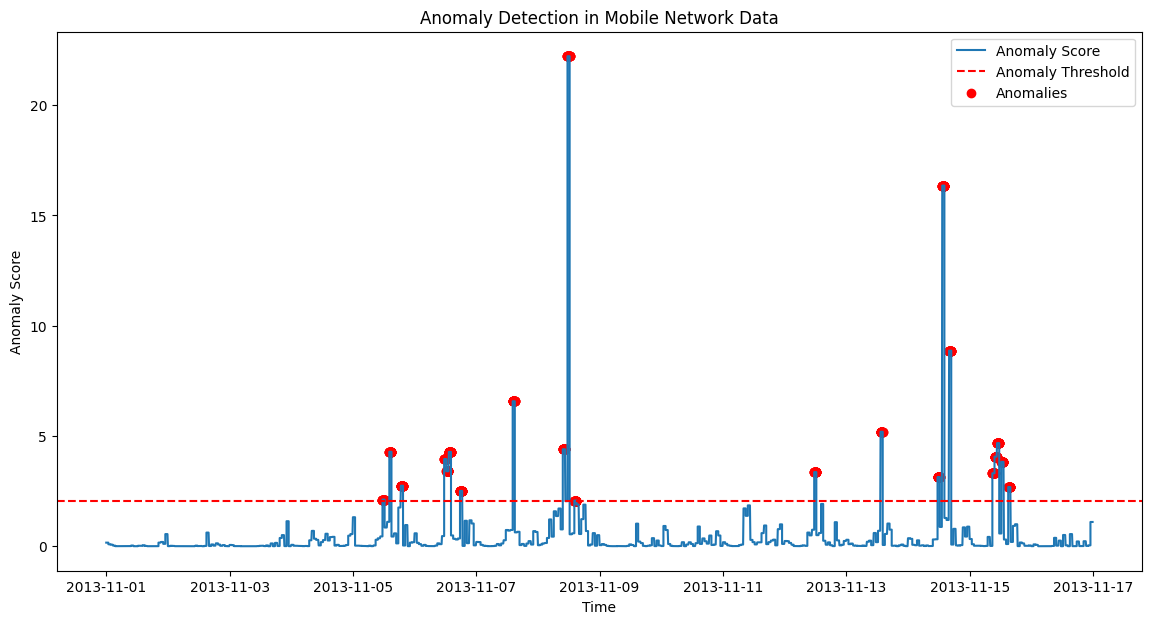

,Timestamp,GridID
startTime,,
2013-11-05 11:30:00,2013-11-05 11:30:00,4560
2013-11-05 11:30:00,2013-11-05 11:30:00,5763
2013-11-05 11:30:00,2013-11-05 11:30:00,5063
2013-11-05 11:30:00,2013-11-05 11:30:00,5216
2013-11-05 11:40:00,2013-11-05 11:40:00,4560
...,...,...
2013-11-15 15:50:00,2013-11-15 15:50:00,5216
2013-11-15 15:50:00,2013-11-15 15:50:00,5447
2013-11-15 15:50:00,2013-11-15 15:50:00,5763


In [151]:
anomaly_threshold = np.percentile(anomalies, 95)  # For example, using the 95th percentile as the threshold
anomaly_indices = np.where(anomalies > anomaly_threshold)[0]
anomaly_timestamps = test_timestamps[anomaly_indices]
anomaly_grid_ids = test_grid_ids[anomaly_indices]

# Visualize anomalies
plt.figure(figsize=(14, 7))
plt.plot(test_timestamps, anomalies, label='Anomaly Score') # Слагам [0:1786], защото иначе ми дава грешка
plt.axhline(y=anomaly_threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.scatter(anomaly_timestamps, anomalies[anomaly_indices], color='red', label='Anomalies')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Detection in Mobile Network Data')
plt.legend()
plt.show()

# Display anomaly timestamps and grid IDs
anomaly_info = pd.DataFrame({'Timestamp': anomaly_timestamps, 'GridID': anomaly_grid_ids})
display(anomaly_info)
#anomaly_info.to_csv('anomalies_zscore_dec_mask_v2.csv')

#### Model Performance

#### Results Functions

In [152]:
def model_perf(orig, pred):
    # orig = ground true values as a panda series
    # pred = predicted values as a panda series
    # Extract True and Predicted values
    true_values = np.where(orig == "Abnormal", 1, 0)  # Convert to binary
    predicted_values = np.where(pred == "Abnormal", 1, 0)    # Convert to binary
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(true_values, predicted_values)
    print("Confusion Matrix:")
    print(conf_matrix)

    # # Extract TP, FP, TN, FN
    TN, FP, FN, TP = conf_matrix.ravel()
    print(f'Type 1 Error:{FP/(TP+FP)}')

    precision =  TP/(TP+FP)
    recall =  TP/(TP+FN)
    f1_score =  2*(precision*recall)/(precision+recall)
    accuracy =  (TP+TN)/(TP+TN+FP+FN)
    
    # Accuracy
    #accuracy = accuracy_score(true_values, predicted_values)
    print(f"Accuracy: {accuracy:.4f}")

    auroc = None  # Initialize auroc variable
    
    # AUROC (requires both true and predicted binary values)
    if len(set(true_values)) > 1 and len(set(predicted_values)) > 1:  # Ensure both classes are present
        auroc = roc_auc_score(true_values, predicted_values)
        print(f"AUROC: {auroc:.4f}")
    else:
        print("AUROC cannot be calculated as only one class is present in the data.")
    
    # Classification Report (Precision, Recall, F1-Score)
    class_report = classification_report(true_values, predicted_values, target_names=["Normal", "Abnormal"])
    print("\nClassification Report:")
    print(class_report)
    return {"precision":precision, "accuracy":accuracy, "recall":recall,"f1_score":f1_score, "auroc":auroc}

In [153]:
# Define colors based on conditions
def assign_color(orig, pred):
    # orig is a np.array containing original labels
    # pred is a np.array containing predicted labels
    # Define colors based on conditions
    colors = np.empty(orig.shape, dtype=object)
    
    colors[(pred == "Abnormal") & (orig == "Abnormal")] = "red"    # Both Abnormal
    colors[(pred == "Abnormal") & (orig == "Normal")] = "orange"  # Predicted Abnormal, Original Normal
    colors[(pred == "Normal") & (orig == "Abnormal")] = "green"   # Predicted Normal, Original Abnormal
    colors[(pred == "Normal") & (orig == "Normal")] = "blue"      # Both Normal
    return colors

In [154]:
def model_perf_plot(x, y, c, t):
    """
    Parameters:
    - x=xaxis values
    - y=yaxis values
    - c=color column map
    - t=title
    
    Returns:
    - None: Displays the plot

    Example: model_perf_plot(x=[1, 2, 3], y=[3, 2, 1], c=['red', 'blue', 'green'], t="Performance Plot")
    """
    plt.figure(figsize=(18, 10))
    plt.subplot(1, 2, 1)
    plt.scatter(x, y, alpha=0.7, c=c, s=1, marker='o', linewidths=0.5)
    plt.title(t)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [156]:
def Thresholding(anomaliesScore, t='zscore', threshold=2.5):
    """
    Apply Z-score or MAD (Median Absolute Deviation) thresholding to identify anomalies based on their scores.

    Parameters:
    - anomaliesScore (array-like): A series or array containing anomaly scores.
    - t (str, optional): Specifies the thresholding method. Can be:
        - 'zscore': Use Z-score thresholding (default).
        - 'mad': Use Median Absolute Deviation (MAD) thresholding.
    - threshold (float, optional): The threshold value for determining anomalies (default is 2.5).

    Returns:
    - finalscoresStatus (numpy array): An array of labels indicating "Abnormal" for scores exceeding the threshold 
      and "Normal" otherwise.

    Raises:
    - ValueError: If `t` is not 'zscore' or 'mad'.

    Example:
    >>> import numpy as np
    >>> scores = np.array([0.5, 2.1, 3.0, 0.7, 1.8])
    >>> Thresholding(scores, t='zscore', threshold=2.0)
    array(['Normal', 'Normal', 'Abnormal', 'Normal', 'Normal'], dtype='<U8')
    >>> Thresholding(scores, t='mad', threshold=2.0)
    array(['Normal', 'Normal', 'Abnormal', 'Normal', 'Normal'], dtype='<U8')
    """

    if t == 'mad':
        # Calculate Median Absolute Deviation (MAD)
        mad = np.median(np.abs(anomaliesScore - np.median(anomaliesScore)))
        finalscores = 0.6745 * (anomaliesScore - np.median(anomaliesScore)) / mad
    elif t == 'zscore':
        # Calculate Z-score
        # # Added absolute value to make it
        # finalscores = np.abs((anomaliesScore - np.mean(anomaliesScore))) / np.std(anomaliesScore)
        # Added absolute value to make it
        #finalscores = (anomaliesScore - np.mean(anomaliesScore)) / np.std(anomaliesScore)
        finalscores = (anomaliesScore - np.mean(anomaliesScore)) / np.std(anomaliesScore)
    elif t == 'chebyshev':
        # Calculate Chebyshev Inequality score
        # # Added absolute value to make it
        finalscores = np.abs((anomaliesScore - np.mean(anomaliesScore))) / np.std(anomaliesScore)
    elif t == 'standard':
        # Calculate Chebyshev Inequality score
        # # Added absolute value to make it
        threshold = np.percentile(anomaliesScore, threshold)
        finalscores = anomaliesScore
    else:
        raise ValueError("Invalid thresholding method. Choose 'zscore', 'chebyshev', 'standard' or 'mad'")

    # Determine the status based on the threshold
    finalscoresStatus = np.where(finalscores >= threshold, "Abnormal", "Normal")
    return finalscoresStatus,finalscores

In [157]:
def BoxcoxTransformation(t):
    """
    Apply the Box-Cox transformation to stabilize variance and make data more normally distributed.

    Parameters:
    - anomaliesScore (array-like): A series or array of anomaly scores. All values must be positive.
    - threshold (float, optional): A threshold value (default is 2.5). 
      Note: This parameter is not currently used in the function.

    Returns:
    - bc (numpy array): The transformed scores after applying the Box-Cox transformation.

    Raises:
    - ValueError: If any value in `anomaliesScore` is not strictly positive.

    Example:
    >>> import numpy as np
    >>> from scipy import stats
    >>> scores = np.array([0.5, 1.2, 2.3, 0.7])
    >>> BoxcoxTransformation(scores)
    array([-0.850213,  0.182321,  1.627393, -0.336472])

    Notes:
    - A small constant (`1e-6`) is added to `anomaliesScore` to avoid issues with zero or negative values.
    - The Box-Cox transformation requires strictly positive input values.
    """
    t = t + 1e-6  # Ensure all values are positive
    bc, lambda_ = stats.boxcox(t)
    return bc

### Results output

In [158]:
rec_out = np.split(reconstructed_data, n_split, axis=0)

In [159]:
len(rec_out)

432

In [160]:
orig_out = np.split(noisy_tensor[:,-1].cpu().numpy(), n_split, axis=0)

In [161]:
rec_error = [np.sqrt(((rec_out[i] - orig_out[i])**2)/len(orig_out[i])) for i in np.arange(0, n_split)]
rec_threshold_up = [np.percentile(rec_error[i],95) for i in np.arange(0, n_split)]
rec_threshold_low = [np.percentile(rec_error[i],5) for i in np.arange(0, n_split)]
rec_status = [np.where(np.logical_or(rec_error[i]>rec_threshold_up[i], rec_error[i]<rec_threshold_low[i]),"Abnormal","Normal") for i in np.arange(0, n_split)]

In [162]:
reconstruction_error = np.concatenate(rec_error)
reconstruction_status = np.concatenate(rec_status)

In [163]:
display(reconstructed_data.shape)
display(reconstruction_error.shape)
display(reconstruction_status.shape)
display(anomalies.shape)

(13824,)

(13824,)

(13824,)

(13824,)

In [164]:
df_res = pd.DataFrame({
     "GridID": test_grid_ids,
     "Original": noisy_tensor.cpu().numpy()[:,0],  # Convert tensor to list
     "Reconstructed": reconstructed_data,  # Last column of reconstructed data as list
     "reconstruction_error": reconstruction_error,
     "reconstruction_status": reconstruction_status,
     "AnomalyScore": anomalies
 })

In [165]:
df_res.index=test_timestamps

In [166]:
threshold=95

In [167]:
## Standard Threshold using losses from model testing
anomaly_threshold = np.percentile(df_res['AnomalyScore'], threshold)
df_res["DetectionStatus"] = np.where(df_res['AnomalyScore'] > anomaly_threshold, "Abnormal", "Normal")

## Reconstruction MSE recalculated
anomaly_thresholdRec = np.percentile(df_res['reconstruction_error'], threshold)
df_res["DetectionStatusReconstruction"] = np.where(df_res['reconstruction_error'] > anomaly_thresholdRec, "Abnormal", "Normal")

df_res["OriginalStatus"] = "Normal"
df_res.iloc[down:up, df_res.columns.get_loc("OriginalStatus")] = "Abnormal"

In [168]:
#anomalies_copy = anomalies.copy()

C:\Users\VCLAB\AppData\Local\Temp\ipykernel_17432\507233585.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anomaly_grid_ids = test_grid_ids[anomaly_indices]
C:\Users\VCLAB\AppData\Local\Temp\ipykernel_17432\507233585.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter(anomaly_timestamps, df_res['AnomalyScore'][anomaly_indices], color='red', label='Anomalies')


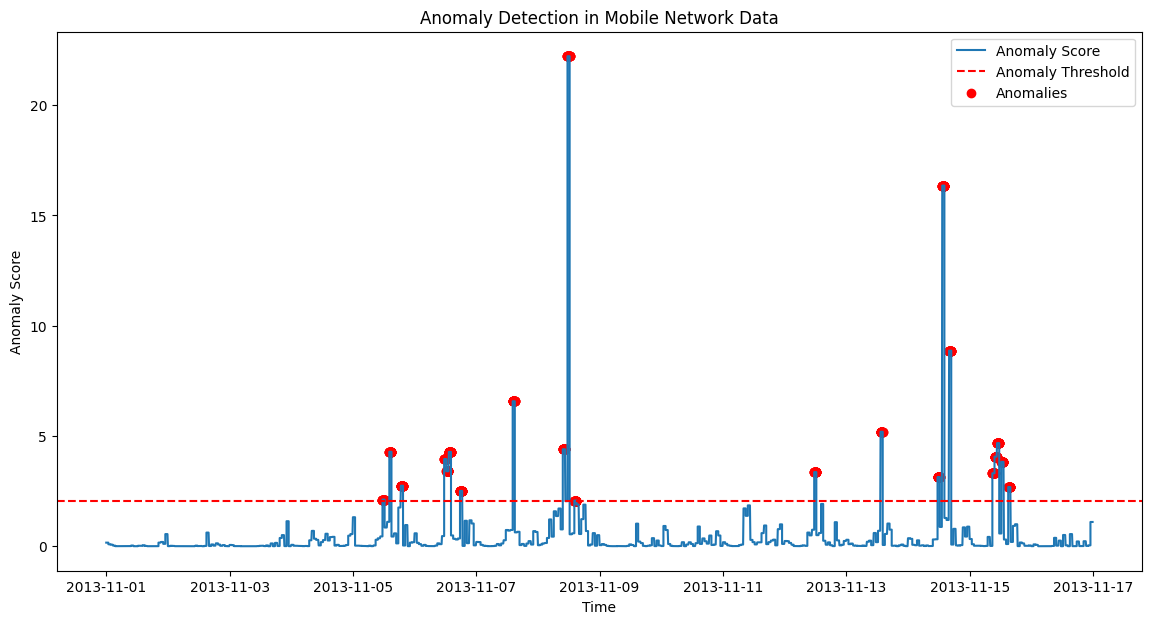

In [169]:
anomaly_threshold = np.percentile(df_res['AnomalyScore'], threshold)  # For example, using the 95th percentile as the threshold
anomaly_indices = np.where(df_res['AnomalyScore'] > anomaly_threshold)[0]
anomaly_timestamps = test_timestamps[anomaly_indices]
anomaly_grid_ids = test_grid_ids[anomaly_indices]

# Visualize anomalies
plt.figure(figsize=(14, 7))
plt.plot(test_timestamps, df_res['AnomalyScore'], label='Anomaly Score') # Слагам [0:1786], защото иначе ми дава грешка
plt.axhline(y=anomaly_threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.scatter(anomaly_timestamps, df_res['AnomalyScore'][anomaly_indices], color='red', label='Anomalies')
plt.xlabel('Time')
plt.ylabel('Anomaly Score')
plt.title('Anomaly Detection in Mobile Network Data')
plt.legend()
plt.show()

# Display anomaly timestamps and grid IDs
anomaly_info = pd.DataFrame({'Timestamp': anomaly_timestamps, 'GridID': anomaly_grid_ids})

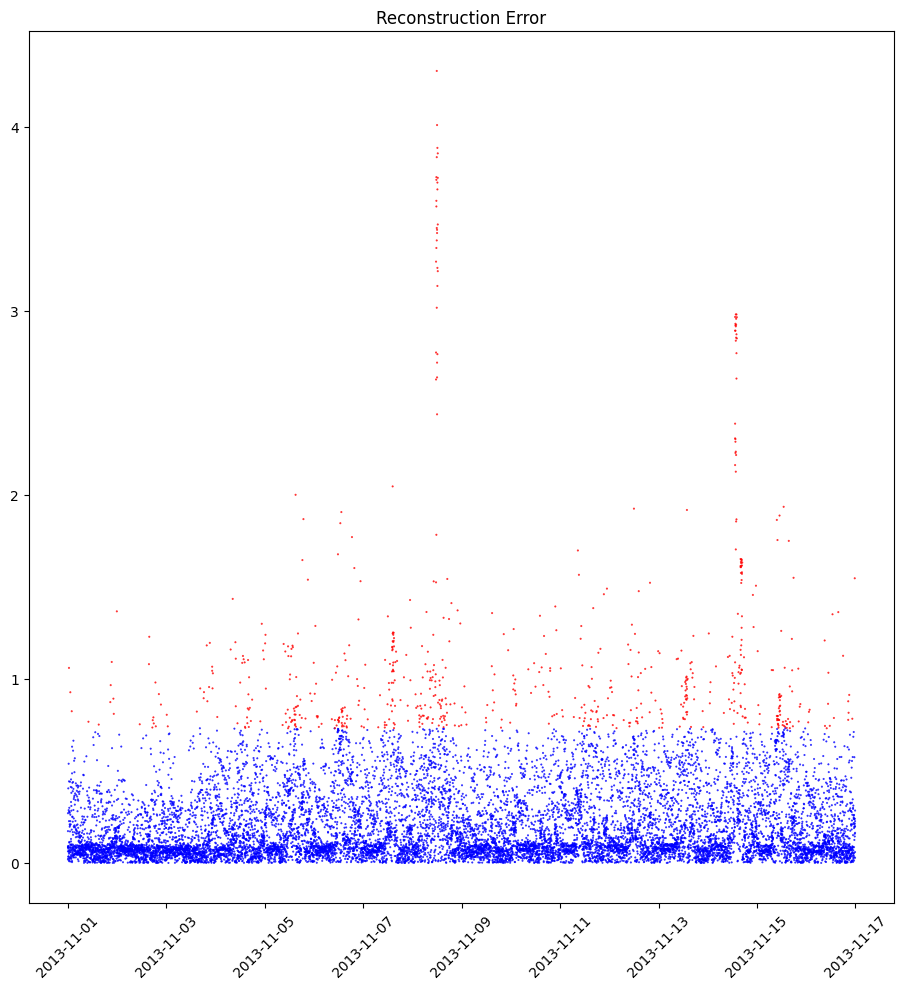

In [170]:
plt.figure(figsize=(18, 10))
plt.subplot(1, 2, 1)
plt.scatter(df_res.index, df_res['reconstruction_error'], c=np.where(df_res['DetectionStatusReconstruction']=="Abnormal",'red','blue'), alpha=0.7, s=1, marker='o', linewidths=0.5)
plt.title("Reconstruction Error")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [171]:
standard_out = model_perf(orig=df_res["OriginalStatus"], pred=df_res["DetectionStatus"])

Confusion Matrix:
[[12748   576]
 [  404    96]]
Type 1 Error:0.8571428571428571
Accuracy: 0.9291
AUROC: 0.5744

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.96      0.96     13324
    Abnormal       0.14      0.19      0.16       500

    accuracy                           0.93     13824
   macro avg       0.56      0.57      0.56     13824
weighted avg       0.94      0.93      0.93     13824



In [172]:
standard_out_rec = model_perf(orig=df_res["OriginalStatus"], pred=df_res["DetectionStatusReconstruction"])

Confusion Matrix:
[[12729   595]
 [  403    97]]
Type 1 Error:0.8598265895953757
Accuracy: 0.9278
AUROC: 0.5747

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.96      0.96     13324
    Abnormal       0.14      0.19      0.16       500

    accuracy                           0.93     13824
   macro avg       0.55      0.57      0.56     13824
weighted avg       0.94      0.93      0.93     13824



#### Zscore Thresholding

In [173]:
zscoreLabels, zscores = Thresholding(df_res["AnomalyScore"], t='zscore' ,threshold=2.5)
zscore_out = model_perf(orig=df_res["OriginalStatus"], pred=zscoreLabels)

Confusion Matrix:
[[13164   160]
 [  468    32]]
Type 1 Error:0.8333333333333334
Accuracy: 0.9546
AUROC: 0.5260

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98     13324
    Abnormal       0.17      0.06      0.09       500

    accuracy                           0.95     13824
   macro avg       0.57      0.53      0.53     13824
weighted avg       0.94      0.95      0.94     13824



In [174]:
chebyshevLabels, chebyshevscores = Thresholding(df_res["AnomalyScore"], t='chebyshev' ,threshold=2.58)
chebyshev_out = model_perf(orig=df_res["OriginalStatus"], pred=chebyshevLabels)

Confusion Matrix:
[[13164   160]
 [  468    32]]
Type 1 Error:0.8333333333333334
Accuracy: 0.9546
AUROC: 0.5260

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98     13324
    Abnormal       0.17      0.06      0.09       500

    accuracy                           0.95     13824
   macro avg       0.57      0.53      0.53     13824
weighted avg       0.94      0.95      0.94     13824



In [175]:
zscoreLabelsRec, zscoresRec = Thresholding(df_res["reconstruction_error"], t='zscore', threshold=2.5)
zscore_outRec = model_perf(orig=df_res["OriginalStatus"], pred=zscoreLabelsRec)

Confusion Matrix:
[[13079   245]
 [  450    50]]
Type 1 Error:0.8305084745762712
Accuracy: 0.9497
AUROC: 0.5408

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.97     13324
    Abnormal       0.17      0.10      0.13       500

    accuracy                           0.95     13824
   macro avg       0.57      0.54      0.55     13824
weighted avg       0.94      0.95      0.94     13824



#### Zscore Thresholding with BoxCox Transformation

In [176]:
bczscores = BoxcoxTransformation(df_res['AnomalyScore'])
bczscoreLabels, bczscores = Thresholding(bczscores, t='zscore', threshold=2.5)
bc_out= model_perf(orig=df_res["OriginalStatus"], pred=bczscoreLabels)

Confusion Matrix:
[[13324     0]
 [  500     0]]
Type 1 Error:nan
Accuracy: 0.9638
AUROC cannot be calculated as only one class is present in the data.

Classification Report:
              precision    recall  f1-score   support

      Normal       0.96      1.00      0.98     13324
    Abnormal       0.00      0.00      0.00       500

    accuracy                           0.96     13824
   macro avg       0.48      0.50      0.49     13824
weighted avg       0.93      0.96      0.95     13824



C:\Users\VCLAB\AppData\Local\Temp\ipykernel_17432\2354042476.py:15: RuntimeWarning: invalid value encountered in scalar divide
  print(f'Type 1 Error:{FP/(TP+FP)}')
C:\Users\VCLAB\AppData\Local\Temp\ipykernel_17432\2354042476.py:17: RuntimeWarning: invalid value encountered in scalar divide
  precision =  TP/(TP+FP)
c:\Users\VCLAB\anaconda3\envs\anomalyDetectionN\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\VCLAB\anaconda3\envs\anomalyDetectionN\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resul

#### MAD Thresholding

In [178]:
madLabels, _ = Thresholding(df_res["AnomalyScore"], t="mad", threshold=2.5)
mad_out = model_perf(orig=df_res["OriginalStatus"], pred=madLabels)

Confusion Matrix:
[[9943 3381]
 [   9  491]]
Type 1 Error:0.8731921487603306
Accuracy: 0.7548
AUROC: 0.8641

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.75      0.85     13324
    Abnormal       0.13      0.98      0.22       500

    accuracy                           0.75     13824
   macro avg       0.56      0.86      0.54     13824
weighted avg       0.97      0.75      0.83     13824



In [179]:
madLabelsRec, _ = Thresholding(df_res["reconstruction_error"], t="mad", threshold=2.5)
mad_out_rec = model_perf(orig=df_res["OriginalStatus"], pred=madLabelsRec)

Confusion Matrix:
[[11184  2140]
 [  291   209]]
Type 1 Error:0.9110259684972328
Accuracy: 0.8241
AUROC: 0.6287

Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.84      0.90     13324
    Abnormal       0.09      0.42      0.15       500

    accuracy                           0.82     13824
   macro avg       0.53      0.63      0.52     13824
weighted avg       0.94      0.82      0.87     13824



In [180]:
## Compiled results
out=np.transpose(pd.DataFrame({'standard':standard_out, 'zscore':zscore_out,  'chebyshev':chebyshev_out, 'boxcox':bc_out, 'mad':mad_out}))
# out = out.sort_values(['f1_score'], ascending=False)
styled_df = out.style.highlight_max(axis=0, color='green')
styled_df

,precision,accuracy,recall,f1_score,auroc
standard,0.142857,0.929109,0.192000,0.163823,0.574385
zscore,0.166667,0.954572,0.064000,0.092486,0.525996
chebyshev,0.166667,0.954572,0.064000,0.092486,0.525996
boxcox,nan,0.963831,0.000000,nan,nan
mad,0.126808,0.754774,0.982000,0.224611,0.864124


In [ ]:
# current_date = datetime.datetime.today().strftime('%Y-%m-%d')

In [182]:
out.to_csv(f'{col}_enc{mask_type}mask_results_{current_date}.csv')

In [183]:
col, f'{col}_enc{mask_type}mask_results_{current_date}.csv'

('Internet', 'Internet_enczscoremask_results_2025-04-03.csv')

In [184]:
mask_type

'zscore'

### Validation with out artificial outliers

In [180]:
start_time=time.time()
eval_loader = DataLoader(TensorDataset(date_eval_tensor, eval_tensor_2[:date_eval_tensor.shape[0]]), batch_size=32, shuffle=False) ## Only for Copulas - test tensor

anomalies = []
anomalies_zs = []
anomalies_mad = []
anomalies_cheb = []
anomalies_std = []
anomalies_zs_lab = []
anomalies_mad_lab = []
anomalies_cheb_lab = []
anomalies_std_lab = []
reconstructed_data = []


window_losses = []  # Initialize the window_losses list outside the loop to accumulate across batches

with torch.no_grad():
    for i, (t, d) in enumerate(eval_loader):
        # Prepare the inputs for the model
        x_enc = torch.unsqueeze(d, 1).expand(d.size(0), seq_len, d.size(-1))
        x_dec = torch.unsqueeze(d, 1).expand(d.size(0), math.ceil(seq_len/2), d.size(-1))
        x_mark_enc = torch.unsqueeze(t, 1).expand(t.size(0), seq_len, t.size(-1))
        x_mark_dec = torch.unsqueeze(t, 1).expand(t.size(0), math.ceil(seq_len/2), t.size(-1))
        
        # Get model predictions
        pred = first_model(x_enc, x_mark_enc, x_dec, x_mark_dec, enc_self_mask=mask_type)
        reconstructed_data.append(pred.cpu().numpy())        
        # Calculate loss
        loss = criterion(pred, x_dec)
        
        anomalies.extend(loss.item() for _ in range(x_dec.size(0)))
torch.cuda.empty_cache()
print(f'Processing time is {time.time() - start_time}')

mad tensor(0.6875, device='cuda:0')
mad tensor(0.6250, device='cuda:0')
mad tensor(0.8125, device='cuda:0')
mad tensor(0.7188, device='cuda:0')
mad tensor(0.5625, device='cuda:0')
mad tensor(0.5625, device='cuda:0')
mad tensor(0.8125, device='cuda:0')
mad tensor(0.7812, device='cuda:0')
mad tensor(0.8125, device='cuda:0')
mad tensor(0.7188, device='cuda:0')
mad tensor(0.7812, device='cuda:0')
mad tensor(0.7812, device='cuda:0')
mad tensor(0.7812, device='cuda:0')
mad tensor(0.7500, device='cuda:0')
mad tensor(0.7812, device='cuda:0')
mad tensor(0.8750, device='cuda:0')
mad tensor(0.7812, device='cuda:0')
mad tensor(0.9375, device='cuda:0')
mad tensor(0.9062, device='cuda:0')
mad tensor(0.9375, device='cuda:0')
mad tensor(0.8750, device='cuda:0')
mad tensor(0.9688, device='cuda:0')
mad tensor(0.9375, device='cuda:0')
mad tensor(0.9375, device='cuda:0')
mad tensor(0.7812, device='cuda:0')
mad tensor(0.7812, device='cuda:0')
mad tensor(0.6875, device='cuda:0')
mad tensor(0.9375, device='c

In [181]:
np.size(anomalies)

32400

In [183]:
anomailes_copy= anomalies.copy()
reconstructed_data_copy = reconstructed_data.copy()

### Repeat from here

In [184]:
anomalies = np.array(anomailes_copy)
reconstructed_data = np.vstack(reconstructed_data_copy)

In [185]:
reconstructed_data.shape

(32400, 72, 1)

In [186]:
def plot_reconstruction_for_grid_id(grid_id, unique_grids, original_data, reconstructed_data, timestamps):
    fig, axs = plt.subplots(2, 1, figsize=(20, 10))
    columns = [col]

    grid_mask = unique_grids == grid_id
    for i, column in enumerate(columns):
        axs[i].plot(timestamps[grid_mask], original_data[grid_mask, i], label='Original')
        axs[i].plot(timestamps[grid_mask], reconstructed_data[grid_mask, i], label='Reconstructed')
        #axs[i].plot(timestamps[grid_mask], anomalies[grid_mask, i], label='Anomalies')
        axs[i].set_title(f'{column} - Original vs Reconstructed for GridID {grid_id}')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

### Comparing Zscore Thresholding to Standard Detection

In [187]:
## Standard Threshold using losses from model testing
standardLabels, _ = Thresholding(anomalies, t="standard", threshold=95)
zscoreLabels, _ = Thresholding(anomalies, t="zscore",threshold=2.5)
bczscores = BoxcoxTransformation(anomalies)
bczscoreLabels, _ = Thresholding(bczscores, t="zscore",threshold=2.5)
madLabels, _ = Thresholding(anomalies, t="mad", threshold=2.5)
chebyshevLabels, _ = Thresholding(anomalies, t="chebyshev", threshold=2.5)

In [188]:
df_res_eval = pd.DataFrame({
    "GridID": data_eval_scaled['gridID'],
    "Original": eval_tensor_2.cpu().numpy()[:,0],  # Convert tensor to list
    "Reconstructed": reconstructed_data[:, -1, -1],  # Last column of reconstructed data as list
    "AnomalyScore": anomalies,
    "standard":standardLabels,
    "zscore": zscoreLabels,  # Convert tensor to list
    "boxcox": bczscoreLabels,  # Last column of reconstructed data as list
    "mad": madLabels,
    "chebyshev":chebyshevLabels
})

df_res_eval.index=data_eval_2.index

In [189]:
df_res_eval.head()

,GridID,Original,Reconstructed,AnomalyScore,standard,zscore,boxcox,mad,chebyshev
startTime,,,,,,,,,
2013-11-18,839,0.033565,0.178295,0.263959,Abnormal,Normal,Normal,Abnormal,Normal
2013-11-18,2621,-0.577075,-0.544871,0.263959,Abnormal,Normal,Normal,Abnormal,Normal
2013-11-18,8906,0.661259,0.780340,0.263959,Abnormal,Normal,Normal,Abnormal,Normal
2013-11-18,4707,-0.178234,-0.023622,0.263959,Abnormal,Normal,Normal,Abnormal,Normal
2013-11-18,7285,1.989145,2.018374,0.263959,Abnormal,Normal,Normal,Abnormal,Normal


In [191]:
df_eval_final_res=np.transpose(pd.DataFrame({"standard":pd.Series(standard_out),
                                "zscore":pd.Series(zscore_out), 
                                "chebyshev":pd.Series(chebyshev_out), 
                                "boxcox":pd.Series(bc_out), 
                                "mad":pd.Series(mad_out)}))

In [192]:
## Compiled results
df_eval_final_res = df_eval_final_res.sort_values(['f1_score'], ascending=False)
df_eval_final_res

,precision,accuracy,recall,f1_score,auroc
mad,0.127818,0.753617,0.998,0.226612,0.871223
standard,0.190476,0.933738,0.256,0.218430,0.607586
zscore,0.090909,0.942998,0.064,0.075117,0.519992
chebyshev,0.090909,0.942998,0.064,0.075117,0.519992
boxcox,NaN,0.963831,0.000,NaN,NaN


In [193]:
df_eval_final_res.transpose()

,mad,standard,zscore,chebyshev,boxcox
precision,0.127818,0.190476,0.090909,0.090909,NaN
accuracy,0.753617,0.933738,0.942998,0.942998,0.963831
recall,0.998000,0.256000,0.064000,0.064000,0.000000
f1_score,0.226612,0.218430,0.075117,0.075117,NaN
auroc,0.871223,0.607586,0.519992,0.519992,NaN


In [ ]:
df_eval_final_res.to_csv(f"output/eval_results_perf_vs_standard_{col}_{mask_type}_{current_date}.csv")

In [194]:
df_res_eval['standard'].value_counts().iloc[0]

np.int64(30768)

In [195]:
out['score']=out['recall']*out['f1_score']
best_model = out['f1_score'].idxmax()
print(f"Best model {best_model}")

Best model mad


In [196]:
## Selecting the best model for plotting
print(f"Best model {best_model}")

anomaly_indices = np.where((df_res_eval[best_model]=='Abnormal'))[0]
anomaly_timestamps = df_res_eval.index[anomaly_indices]
anomaly_grid_ids = data_eval_scaled['gridID'][anomaly_indices]

Best model mad


C:\Users\VCLAB\AppData\Local\Temp\ipykernel_21300\1872402655.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anomaly_grid_ids = data_eval_scaled['gridID'][anomaly_indices]


In [ ]:
# df_eval_compare = pd.DataFrame({'standard':df_res_eval["DetectionStatus"],'zscore':zscoreLabels, 'boxcox':bczscoreLabels, 'mad':madLabels, 'chebyshev':chebyshevLabels})

In [197]:
abnormal_mask = df_res_eval[best_model] == 'Abnormal'

In [198]:
df_res_eval.index.shape

(32400,)

#### FIle to be returned

In [ ]:
df_out_cnt = pd.DataFrame({"method":['standard','zscore', 'boxcox', 'mad', 'chebyshev'],
                           "Normal":[df_res_eval[c].value_counts().iloc[0] for c in ['standard','zscore', 'boxcox', 'mad', 'chebyshev']],
                          "Abnormal":[df_res_eval[c].value_counts().iloc[1] for c in ['standard','zscore', 'boxcox', 'mad', 'chebyshev']]})

In [ ]:
df_out_cnt

In [ ]:
df_out_cnt.to_csv(f"output/outliers_count_{col}_{mask_type}_{current_date}.csv")